# Image Captioning using Deep Learning: Assignment-2

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [2]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim as optim
from mlxtend.data import loadlocal_mnist
import platform
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as f

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [3]:
import torchvision
from torchvision import transforms, datasets

train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

/home/atishayjain/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Your Code from here...

- Loading the dataset using loadlocal_mnist function
- Normalizing it by subtracting the mean to shift the data and then divding by its standard deviation
- Using train_test_split function for splitting the dataset

In [4]:
# load the data set

if not platform.system() == 'Windows':
    X, y = loadlocal_mnist(
            images_path='MNIST/raw/train-images-idx3-ubyte', 
            labels_path='MNIST/raw/train-labels-idx1-ubyte')

else:
    X, y = loadlocal_mnist(
            images_path='MNIST/raw/train-images.idx3-ubyte', 
            labels_path='MNIST/raw/train-labels.idx1-ubyte')

# normalize the dataset, won't be doing it here in later assignments
Std = np.std(X,axis=0,keepdims=True)
Mean = np.mean(X,axis=0,keepdims=True)
normalized_data = (X - Mean)/(Std + 10**(-7))

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library

X_train,X_test,y_train,y_test = train_test_split(normalized_data, y, test_size=0.8)

Dimensions of data

In [5]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X.shape, y.shape)

(12000, 784) (12000,)
(48000, 784) (48000,)
(60000, 784) (60000,)


### 4x4 grid of 16 random images from dataset with label

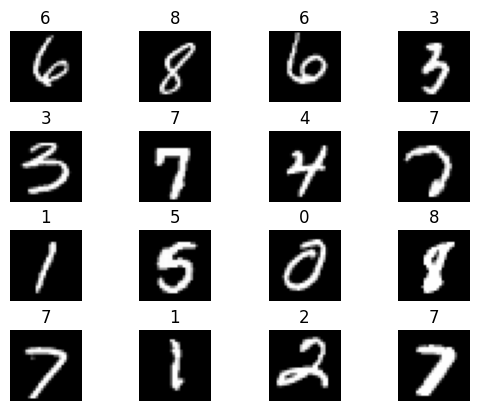

In [6]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
for i in range(16):
    plt.subplot(4,4,i+1)
    rand_index = random.randrange(0,60000)
    img = X[rand_index].reshape(28,28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(y[rand_index])
plt.subplots_adjust(hspace=0.4)
plt.show()

### Dataset Class

In [7]:
# define your dataset for pre-processing into Neural Network

class MNIST_dataset(Dataset):
    def __init__(self,x_,y_):
        self.images = x_
        self.labels = y_
    def __len__(self):
        return len(self.images)
    def __getitem__(self,i):
        image = self.images[i]
        label = self.labels[i]
        return image, label

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [8]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28*28,512)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512,512)
        self.layer3 = nn.Linear(512,256)
        self.layer4 = nn.Linear(256,64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.layer5 = nn.Linear(64,64)
        self.final = nn.Linear(64,10)
    def forward(self,x):
        x = f.relu(self.batch_norm1(self.layer1(x)))
        x = f.relu(self.layer2(x))
        x = f.relu(self.layer3(x))
        x = f.relu(self.batch_norm2(self.layer4(x)))
        x = f.relu(self.layer5(x))
        x = self.final(x)
        x = f.log_softmax(x,dim=1)
        return x        

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [9]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    num_epochs = 15
    for epoch in range(num_epochs):
        for data in train_loader:
            X_batch, y_batch = data
            result = model.forward(X_batch.float())
            optimizer.zero_grad()
            y_batch = y_batch.type(torch.LongTensor)
            loss = criterion(result, y_batch)
            loss.backward()
            optimizer.step()
        if ( ((epoch) % display_step == 0) or (epoch == num_epochs - 1)) and display_step:
            print(f"Loss after {epoch+1} epochs is: {loss.item()}")

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [10]:
def predict(model, X_test):
    X_test1 = torch.from_numpy(X_test).float()
    scores = model.forward(X_test1)
    model_scores = scores.detach().numpy()
    preds = model_scores.argmax(axis=1, keepdims=True)
    return preds

Considering accuracy as the percentage of predicted values that match with provided data

In [11]:
def accuracy(pred, labels):
    acc = 0
    j = 0
    for i in pred:
        if i == labels[j]:
            acc += 1
        j += 1
    return 100*(acc/len(pred))

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [12]:
training_model = Net()
optimizer = optim.Adagrad(training_model.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_dataset(X_train, y_train)
train_data_loader = DataLoader(train_data, batch_size=128, shuffle=True)
train(training_model,optimizer,criterion,train_data_loader,display_step = 1)

Loss after 1 epochs is: 0.2812732458114624
Loss after 2 epochs is: 0.26031869649887085
Loss after 3 epochs is: 0.24434995651245117
Loss after 4 epochs is: 0.029148472473025322
Loss after 5 epochs is: 0.029482021927833557
Loss after 6 epochs is: 0.05561463534832001
Loss after 7 epochs is: 0.007009716238826513
Loss after 8 epochs is: 0.00566849485039711
Loss after 9 epochs is: 0.007014326751232147
Loss after 10 epochs is: 0.002015921985730529
Loss after 11 epochs is: 0.0010512570152059197
Loss after 12 epochs is: 0.008070969954133034
Loss after 13 epochs is: 0.005970034748315811
Loss after 14 epochs is: 0.001379251480102539
Loss after 15 epochs is: 0.003065631026402116


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [13]:
prediction_result = predict(training_model, X_test)
print(f'Accuracy: {accuracy(prediction_result,y_test)}')

Accuracy: 96.45208333333333


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

- I was not using google colab, therefore I directly saved the model into ```ass_2.pt``` file as shown below

In [14]:
#from google.colab import files
torch.save(training_model, 'ass_2.pt')
#files.download('ass_2.pt') # download the file from the Colab session for submission

Check if it got saved right!

Predicting some image labels using the final model -

/home/atishayjain/.local/lib/python3.8/site-packages/matplotlib/text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


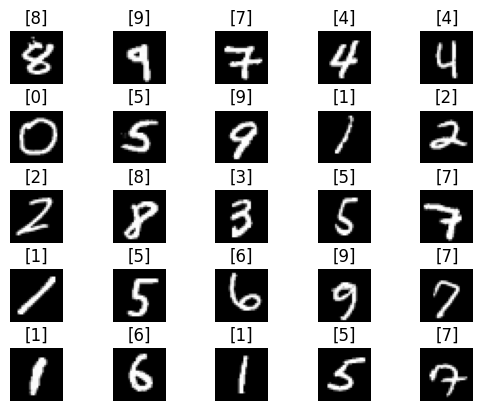

Accuracy for the dataset:  96.85333333333334


In [15]:
# load the model, use predict function

final_model = torch.load('ass_2.pt')
predictions = predict(final_model, X)
plt.figure()
for i in range(25):
    index = random.randrange(X.shape[0])
    plt.subplot(5,5,i+1)
    plt.imshow(X[index].reshape(28,28), cmap= 'gray')
    plt.title(predictions[index])
    plt.axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()
print("Accuracy for the dataset: ", accuracy(predictions,y))